In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [97]:
card_data = pd.read_csv('대분류.csv')
print('훈련용 리뷰 개수 :',len(card_data)) # 훈련용 리뷰 개수 출력
card_data.head()

훈련용 리뷰 개수 : 1000


,발화,대분류
0,상담직원과 빠른연결했슴좋겠어요,불만
1,안기다리고. 빨리상담되었음좋겠다,불만
2,너무 오래기다리고 상담이 늦어져요,불만
3,상담직원과 통화가 매우 힘들다,불만
4,상담받으려면오래기다리는게불편함,불만


In [98]:
card_data['대분류'] = card_data['대분류'].replace('칭찬',0)
card_data['대분류'] = card_data['대분류'].replace('불만',1)
card_data['대분류'] = card_data['대분류'].replace('중립',2)
df_new = card_data.rename(columns={'발화': 'context','대분류': 'label'})
# Null 값 유무
print(df_new.isnull().values.any())


# 중립은 버리기
dfdrop = df_new[df_new['label'] == 2].index
df_new = df_new.drop(dfdrop)

train_data, test_data = train_test_split(df_new, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))


False
훈련용 리뷰의 개수 : 744
테스트용 리뷰의 개수 : 249


   label  count
0      0    354
1      1    390


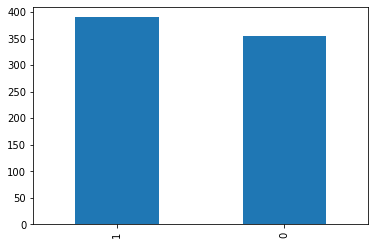

In [99]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [100]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0    354
1      1    390


In [101]:
# 데이터 정제하기 

# 한글과 공백을 제외하고 모두 제거
train_data['context'] = train_data['context'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['context'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
print('전처리 후 학습용 샘플의 개수 :',len(train_data))

test_data.drop_duplicates(subset = ['context'], inplace=True) # 중복 제거
test_data['context'] = test_data['context'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['context'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

context    0
label      0
dtype: int64
전처리 후 학습용 샘플의 개수 : 744
전처리 후 테스트용 샘플의 개수 : 249


<ipython-input-101-4d89620dc847>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['context'] = train_data['context'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/home/khw/anaconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/khw/anaconda3/envs/nlp/lib/python3.9/site-packages/pandas/core/generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/khw/anaconda3/envs/nlp/lib/p

In [102]:
# 토큰화
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

# 불용어 지정
# stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [103]:
train_data['tokenized'] = train_data['context'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['context'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [104]:
negative_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(50))

[('하', 219), ('상담', 133), ('연결', 98), ('게', 88), ('을', 87), ('상담원', 83), ('고', 79), ('너무', 78), ('좋', 71), ('통화', 67), ('다', 67), ('시간', 63), ('되', 61), ('친절', 60), ('으면', 54), ('화면', 54), ('겠', 53), ('습니다', 52), ('음', 50), ('길', 45), ('주', 44), ('합니다', 43), ('직원', 42), ('지', 40), ('해', 40), ('대기', 39), ('었', 38), ('있', 38), ('함', 37), ('기', 37), ('불편', 34), ('할', 33), ('고객', 32), ('면', 31), ('로', 30), ('전화', 30), ('시', 30), ('것', 30), ('연회비', 29), ('없', 28), ('더', 27), ('보이', 26), ('안', 25), ('터치', 25), ('사', 24), ('했', 24), ('많', 23), ('않', 23), ('정확', 23), ('어요', 22)]


In [105]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(50))

[('친절', 252), ('감사', 252), ('하', 187), ('상담', 180), ('합니다', 161), ('주', 94), ('게', 88), ('해', 83), ('고', 70), ('셔서', 52), ('습니다', 44), ('을', 44), ('좋', 33), ('드립니다', 31), ('카드', 26), ('시', 26), ('있', 26), ('했', 25), ('너무', 24), ('해서', 20), ('사', 19), ('함', 19), ('상담원', 18), ('고객', 18), ('다', 18), ('직원', 18), ('분', 16), ('되', 16), ('전화', 16), ('네요', 15), ('어', 15), ('다른', 14), ('었', 14), ('서비스', 14), ('받', 13), ('설명', 12), ('는데', 11), ('았', 11), ('까지', 11), ('어요', 10), ('회사', 10), ('요', 10), ('셨', 9), ('신속', 9), ('음', 9), ('것', 9), ('니', 9), ('때', 9), ('연결', 9), ('적', 9)]


긍정 리뷰의 평균 길이 : 8.96045197740113
부정 리뷰의 평균 길이 : 12.325641025641026


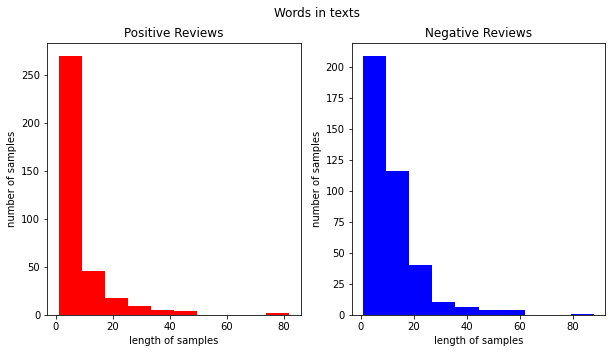

In [106]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [107]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [108]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [109]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1200
등장 빈도가 1번 이하인 희귀 단어의 수: 664
단어 집합에서 희귀 단어의 비율: 55.333333333333336
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.32184484271212


In [110]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 538


In [111]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 10.724462365591398


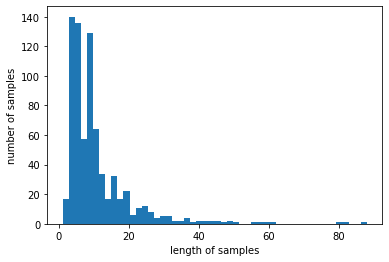

In [112]:
# 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [113]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [114]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.73118279569893


In [115]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [116]:
# BiLSTM

In [117]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [118]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))

In [119]:
mc = ModelCheckpoint('BiLSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [120]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, callbacks=[mc], batch_size=128, validation_split=0.2)

Epoch 1/50
5/5 [==============================] - 3s 285ms/step - loss: 0.6905 - acc: 0.5479 - val_loss: 0.6814 - val_acc: 0.6644

Epoch 00001: val_acc improved from -inf to 0.66443, saving model to BiLSTM_model.h5
Epoch 2/50
5/5 [==============================] - 1s 168ms/step - loss: 0.6723 - acc: 0.6471 - val_loss: 0.6597 - val_acc: 0.6174

Epoch 00002: val_acc did not improve from 0.66443
Epoch 3/50
5/5 [==============================] - 1s 141ms/step - loss: 0.6311 - acc: 0.6975 - val_loss: 0.6030 - val_acc: 0.6913

Epoch 00003: val_acc improved from 0.66443 to 0.69128, saving model to BiLSTM_model.h5
Epoch 4/50
5/5 [==============================] - 1s 163ms/step - loss: 0.5707 - acc: 0.7546 - val_loss: 0.5540 - val_acc: 0.6980

Epoch 00004: val_acc improved from 0.69128 to 0.69799, saving model to BiLSTM_model.h5
Epoch 5/50
5/5 [==============================] - 1s 168ms/step - loss: 0.4854 - acc: 0.7580 - val_loss: 0.4526 - val_acc: 0.8591

Epoch 00005: val_acc improved from 0.

In [121]:
loaded_model = load_model('BiLSTM_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

8/8 [==============================] - 1s 16ms/step - loss: 0.4076 - acc: 0.8394

 테스트 정확도: 0.8394


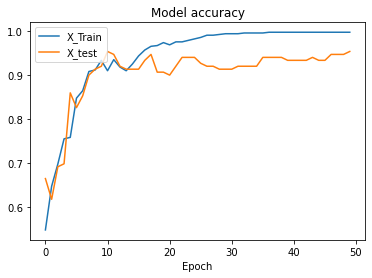

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['X_Train','X_test'], loc='upper left')
plt.show()

In [123]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 불만 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 칭찬 리뷰입니다.".format((1 - score) * 100))

In [124]:
sentiment_predict('고마워요')
sentiment_predict('다른 카드사보다 좋아요')
sentiment_predict('친절에 감사')
sentiment_predict('친절한 언냐 감사합니다.')
sentiment_predict('1등 기업인만큼 우수하다 생각함.')

56.24% 확률로 불만 리뷰입니다.
72.04% 확률로 칭찬 리뷰입니다.
73.79% 확률로 칭찬 리뷰입니다.
91.21% 확률로 칭찬 리뷰입니다.
79.97% 확률로 불만 리뷰입니다.


In [125]:
sentiment_predict('직원이 퉁명스러움')
sentiment_predict('성의없는 답변')
sentiment_predict('더욱 친절하게 대해주세요')
sentiment_predict('통화 대기시간이 너무 길다.')
sentiment_predict('무이자에 대한 혜택이 더 많았으면 좋겠음')

89.34% 확률로 불만 리뷰입니다.
88.42% 확률로 불만 리뷰입니다.
62.84% 확률로 불만 리뷰입니다.
99.01% 확률로 불만 리뷰입니다.
99.16% 확률로 불만 리뷰입니다.


In [126]:
sentiment_predict('터시식 화면')
sentiment_predict('보이는 화면')
sentiment_predict('화면연결')
sentiment_predict('바로보는 화면 서비스')

81.83% 확률로 불만 리뷰입니다.
81.38% 확률로 불만 리뷰입니다.
85.66% 확률로 불만 리뷰입니다.
76.92% 확률로 불만 리뷰입니다.
